In [1]:
# python version: 3.9


import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
import re
import warnings

warnings.filterwarnings('ignore')

# read data

In [2]:
# read data
train_data = pd.read_csv("Train.csv", sep=',')
test_data = pd.read_csv("Test.csv", sep=',')
#separating instance and label for Train
X_train_raw = [x[0] for x in train_data[['text']].values]
Y_train = [x[0] for x in train_data[['sentiment']].values]
X_test_raw = [x[0] for x in test_data[['text']].values]

# data cleaning

In [3]:
reference: https://gist.github.com/jiahao87/d57a2535c2ed7315390920ea9296d79f

from bs4 import BeautifulSoup
import spacy
import unidecode
from word2number import w2n
import contractions

nlp = spacy.load('en_core_web_sm')

def strip_html_tags(text):
    """remove html tags from text"""
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text


def remove_whitespace(text):
    """remove extra whitespaces from text"""
    text = text.strip()
    return " ".join(text.split())


def remove_accented_chars(text):
    """remove accented characters from text, e.g. café"""
    text = unidecode.unidecode(text)
    return text


def expand_contractions(text):
    """expand shortened words, e.g. don't to do not"""
    text = contractions.fix(text)
    return text


def text_preprocessing(text, accented_chars=True, contractions=True,
                       convert_num=True, extra_whitespace=True,
                       lemmatization=True, lowercase=True, punctuations=True,
                       remove_html=True, remove_num=True, special_chars=True,
                       stop_words=True):
    """preprocess text with default option set to true for all steps"""
    if remove_html == True:  # remove html tags
        text = strip_html_tags(text)
    if extra_whitespace == True:  # remove extra whitespaces
        text = remove_whitespace(text)
    if accented_chars == True:  # remove accented characters
        text = remove_accented_chars(text)
    if contractions == True:  # expand contractions
        text = expand_contractions(text)
    if lowercase == True:  # convert all characters to lowercase
        text = text.lower()

    doc = nlp(text)  # tokenise text

    clean_text = []

    for token in doc:
        flag = True
        edit = token.text
        # remove stop words
        if stop_words == True and token.is_stop and token.pos_ != 'NUM':
            flag = False
        # remove punctuations
        if punctuations == True and token.is_punct and flag == True:
            flag = False
        # remove special characters
        if special_chars == True and token.pos_ == 'SYM' and flag == True:
            flag = False
        # remove numbers
        if remove_num == True and (token.pos_ == 'NUM' or token.text.isnumeric()) \
                and flag == True:
            flag = False
        # convert number words to numeric numbers
        if convert_num == True and token.pos_ == 'NUM' and flag == True:
            edit = w2n.word_to_num(token.text)
        # convert tokens to base form
        elif lemmatization == True and token.lemma_ != "-PRON-" and flag == True:
            edit = token.lemma_
        # append tokens edited and not removed to list
        if edit != "" and flag == True:
            clean_text.append(edit)
    return clean_text

In [4]:
#data clean
clean_train_texts = []
clean_test_texts = []
X_train_need_to_clean = pd.DataFrame(X_train_raw)
X_test_need_to_clean = pd.DataFrame(X_test_raw)

# remove url
X_train_need_to_clean.replace("\b*https?:\S*", '', regex=True, inplace=True)
X_train_need_to_clean.replace("\b*http?:\S*", '', regex=True, inplace=True)
X_test_need_to_clean.replace("\b*https?:\S*", '', regex=True, inplace=True)
X_test_need_to_clean.replace("\b*http?:\S*", '', regex=True, inplace=True)

# delete punct


for i in range(len(X_train_raw)):
    text = ' '.join(text_preprocessing(X_train_need_to_clean[0][i], remove_html=False,  special_chars=False, stop_words=False))
    text = re.sub("[^a-zA-Z]", " ", text)
    clean_train_texts.append(text)

for i in range(len(X_test_raw)):    
    text = ' '.join(text_preprocessing(X_test_need_to_clean[0][i], remove_html=False,  special_chars=False, stop_words=False))
    text = re.sub("[^a-zA-Z]", " ", text)
    clean_test_texts.append(text)
    
X_train_clean = clean_train_texts
X_test_clean = clean_test_texts

# vectorization

In [5]:
#TFIDF
tfidf_vectorizer = TfidfVectorizer(ngram_range=(2,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_clean)
X_test_tfidf = tfidf_vectorizer.transform(X_test_clean)
X_train_tranformed, X_test_transformed = X_train_tfidf, X_test_tfidf
# chi2     
selector = SelectKBest(chi2,k=8000)
X_train_new = selector.fit_transform(X_train_tranformed,Y_train)
X_test_new = selector.transform(X_test_transformed)
train_size = X_train_tranformed.shape[0]
test_size = X_test_transformed.shape[0]
## random hold out
ts = test_size/train_size
X_train_, X_validation, y_train_, y_validation  = train_test_split(X_train_new,Y_train, test_size=ts)
X_train_s, y_train_s = X_train_, y_train_
cv = round(X_train_s.shape[0] / X_validation.shape[0])

# modeling

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import numpy as np
from mlxtend.evaluate import bias_variance_decomp

# this function will take the model and datas, print the evaluation scores and output the precdtion

def evaluate_model(model_name: str, model, X_validation, y_validation, X_test_new, cv=5):
    # base
    print(f"{model_name}: ")

    # validation acc
    validation_scores = cross_val_score(model,X_validation, y_validation, cv=cv)
    vc = np.mean(validation_scores)
    print("Validation accuracy: ",vc )
    
    print("validation acc for each cross:", validation_scores)

    # predictions for test data
    prediction = model.predict(X_test_new)

    validation_label = model.predict(X_validation)
    
    # individual metrics
    precision_m = precision_score(y_validation,validation_label, average = None)
    print('individual precision is ', precision_m)

    recall_m = recall_score(y_validation,validation_label, average = None)
    print('individual recall is ', recall_m)

    # f1
    f1_m = f1_score(y_validation,validation_label, average = None)
    print('individual f1 is ', f1_m)
    
    # macro metrics
    precision_m = precision_score(y_validation,validation_label, average = 'macro')
    print('macro precision is ', precision_m)

    recall_m = recall_score(y_validation,validation_label, average = 'macro')
    print('macro recall is ', recall_m)

    # f1
    f1_m = f1_score(y_validation,validation_label, average = 'macro')
    print('macro f1 is ', f1_m)


    # weighted metrics
    precision_w = precision_score(y_validation,validation_label, average = 'weighted')
    print('weighted precision is ', precision_w)

    recall_w = recall_score(y_validation,validation_label, average = 'weighted')
    print('weighted recall is ', recall_w)

    # f1
    f1_w = f1_score(y_validation,validation_label, average = 'weighted')
    print('weighted f1 is ', f1_w)
    print()
    
    return prediction

## default setting vs randomised search tree

### default settings

In [8]:
# logistic regression
logi_model_default = LogisticRegression().fit(X_train_s, y_train_s)

# svm
svm_model_default = SVC().fit(X_train_s, y_train_s)

# decision tree
dt_model_default = DecisionTreeClassifier().fit(X_train_s, y_train_s)

# random forest
rf_model_default = RandomForestClassifier().fit(X_train_s, y_train_s)

# stacking with logistic meta classifier
estimators = [('svm', svm_model_default), ('log', logi_model_default), ('dt', dt_model_default)]
logi_stacking_default = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=200), n_jobs=-1).fit(X_train_s, y_train_s)

s_label_default = evaluate_model("SVM default", svm_model_default, X_validation, y_validation,X_test_new)
logi_label_default = evaluate_model("Logistic Regression default", logi_model_default, X_validation, y_validation,X_test_new)
dt_label_default = evaluate_model("decision tree default", dt_model_default,X_validation, y_validation,X_test_new)
rf_label_default = evaluate_model("random forest default", rf_model_default, X_validation, y_validation,X_test_new)
logi_s_label_default = evaluate_model("logi_stacking default", logi_stacking_default, X_validation, y_validation,X_test_new)

SVM default: 
Validation accuracy:  0.7004416412270202
validation acc for each cross: [0.71311475 0.7        0.68360656 0.71147541 0.69401148]
individual precision is  [0.70042796 0.73550309 0.74879227]
individual recall is  [0.47439614 0.91424501 0.498713  ]
individual f1 is  [0.5656682  0.81519116 0.59868675]
macro precision is  0.7282411082632333
macro recall is  0.6291180494079045
macro f1 is  0.6598487046887112
weighted precision is  0.7329368728826365
weighted recall is  0.7337268404656501
weighted f1 is  0.7176826975435183

Logistic Regression default: 
Validation accuracy:  0.6023935233125781
validation acc for each cross: [0.60819672 0.60081967 0.5942623  0.60819672 0.60049221]
individual precision is  [0.65714286 0.61019678 0.7742616 ]
individual recall is  [0.02222222 0.97179487 0.23616474]
individual f1 is  [0.04299065 0.74967033 0.36193294]
macro precision is  0.6805337468275354
macro recall is  0.41006061006061006
macro f1 is  0.3848646409106509
weighted precision is  0.6

### RandomisedSearchCV

In [10]:
from sklearn.model_selection import RandomizedSearchCV
# decision tree
dt_hyper = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(2,20,2),
    'min_samples_leaf': range(1,10,1),
    'max_features': ['auto', 'log2']
}
search_dt = RandomizedSearchCV(DecisionTreeClassifier(), dt_hyper, scoring='accuracy', cv=cv, n_iter=800, n_jobs=-1)
dt_result = search_dt.fit(X_train_s, y_train_s)

# logistic regression
logi_hyper = {
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'penalty': ['l1', 'l2', 'none', 'elasticnet'],
    'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000],
    'max_iter': [100, 200, 300],
    'multi_class': ['auto', 'ovr', 'multinomial']
}
search_logi = RandomizedSearchCV(LogisticRegression(n_jobs=-1),logi_hyper, scoring='f1_weighted', cv=cv, n_iter=300, n_jobs=-1)
logi_result = search_logi.fit(X_train_s, y_train_s)

# svm
svm_hyper = {
    'degree': [3, 5, 10, 15],
    'gamma': [1,0.1,0.01,0.001],
    'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmod'],
    'max_iter': [100, 500, 1000],
    'decision_function_shape': ['ovo', 'ovr']
}
search_svm = RandomizedSearchCV(SVC(), svm_hyper, scoring='f1_weighted', cv=cv, n_iter=269)
svm_result = search_svm.fit(X_train_s, y_train_s)

# random forest
rf_hyper = {
    'n_estimators': [90, 100, 115 , 130],
    'criterion': ['gini', 'entropy'],
    'max_depth': range(2,20,2),
    'min_samples_leaf': range(1,10,1),
    'min_samples_split': range(2,10,2),
    'max_features': ['auto', 'log2']
}
search_rf = RandomizedSearchCV(RandomForestClassifier(n_jobs=-1), rf_hyper, scoring='f1_weighted', cv=cv, n_iter=800, n_jobs=-1)
rf_result = search_rf.fit(X_train_s, y_train_s)

In [11]:
# all _para_dict is a hard code version of _result from last cell

# logistic regression
logi_para_dict = {'solver': 'lbfgs', 'penalty': 'none', 'multi_class': 'ovr', 'max_iter': 100, 'C': 1000}
logi_model_randomised = LogisticRegression(solver=logi_para_dict['solver'], penalty=logi_para_dict['penalty'],
                                C=logi_para_dict['C'], max_iter=logi_para_dict['max_iter'],
                                multi_class=logi_para_dict['multi_class']).fit(X_train_s, y_train_s)

# svm
svm_para_dict = {'max_iter': 1000, 'kernel': 'rbf', 'gamma': 1, 'degree': 3, 'decision_function_shape': 'ovr', 'C': 1000}
svm_model_randomised = SVC(degree=svm_para_dict['degree'], gamma=svm_para_dict['gamma'] ,C=svm_para_dict['C'], 
                kernel=svm_para_dict['kernel'], max_iter=svm_para_dict['max_iter'], 
                decision_function_shape=svm_para_dict['decision_function_shape']).fit(X_train_s, y_train_s)

# decision tree
dt_para_dict = {'min_samples_leaf': 8, 'max_features': 'auto','max_depth': 18, 'criterion': 'gini'}
dt_model_randomised = DecisionTreeClassifier().fit(X_train_s, y_train_s)

# random forest
rf_para_dict = {'n_estimators': 90, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 18, 'criterion': 'gini'}
rf_model_randomised = RandomForestClassifier(criterion=rf_para_dict['criterion'], max_depth=rf_para_dict['max_depth'],
                                  max_features='log2', min_samples_leaf=rf_para_dict['min_samples_leaf'], 
                                  min_samples_split=rf_para_dict['min_samples_split'], n_estimators=rf_para_dict['n_estimators'],
                                  random_state=0, n_jobs=-1).fit(X_train_s, y_train_s)

# stacking with logistic meta classifier
estimators = [('svm', svm_model_randomised), ('log', logi_model_randomised), ('dt', dt_model_randomised)]
logi_stacking_randomised = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=200), n_jobs=-1).fit(X_train_s, y_train_s)

s_label_randomised = evaluate_model("SVM randomised", svm_model_randomised, X_validation, y_validation,X_test_new)
logi_label_randomised = evaluate_model("Logistic Regression randomised", logi_model_randomised, X_validation, y_validation,X_test_new)
dt_label_randomised = evaluate_model("decision tree randomised", dt_model_randomised,X_validation, y_validation,X_test_new)
rf_label_randomised = evaluate_model("random forest randomised", rf_model_randomised, X_validation, y_validation,X_test_new)
logi_s_label_randomised = evaluate_model("logi_stacking randomised", logi_stacking_randomised, X_validation, y_validation,X_test_new)

SVM randomised: 
Validation accuracy:  0.43761414220202
validation acc for each cross: [0.46393443 0.44180328 0.41311475 0.42295082 0.44626743]
individual precision is  [0.33194676 0.51898734 0.14207048]
individual recall is  [0.38550725 0.45555556 0.16602317]
individual f1 is  [0.35672776 0.4852071  0.15311573]
macro precision is  0.33100152725376786
macro recall is  0.3356953226518444
macro f1 is  0.3316835293293558
weighted precision is  0.39120970560859525
weighted recall is  0.36989670437776684
weighted f1 is  0.37878865303274095

Logistic Regression randomised: 
Validation accuracy:  0.6287908659341841
validation acc for each cross: [0.62868852 0.63360656 0.61639344 0.64098361 0.6242822 ]
individual precision is  [0.66863034 0.7100346  0.72165899]
individual recall is  [0.43864734 0.87692308 0.503861  ]
individual f1 is  [0.52975496 0.78470363 0.59340659]
macro precision is  0.7001079756615572
macro recall is  0.6064771412597499
macro f1 is  0.635955061817881
weighted precision i

### sub optimal results selected by default and RandomisedSearchCV

In [12]:
# logistic regression
logi_para_dict = {'solver': 'lbfgs', 'penalty': 'none', 'multi_class': 'ovr', 'max_iter': 100, 'C': 1000}
logi_model_subop = LogisticRegression(solver=logi_para_dict['solver'], penalty=logi_para_dict['penalty'],
                                C=logi_para_dict['C'], max_iter=logi_para_dict['max_iter'],
                                multi_class=logi_para_dict['multi_class'], n_jobs=-1).fit(X_train_s, y_train_s)

# svm
svm_model_subop = SVC().fit(X_train_s, y_train_s)

# decision tree
dt_model_subop = DecisionTreeClassifier().fit(X_train_s, y_train_s)

# random forest
rf_model_subop = RandomForestClassifier(n_jobs=-1).fit(X_train_s, y_train_s)

# stacking with logistic meta classifier
estimators = [('svm', svm_model_subop), ('log', logi_model_subop), ('dt', dt_model_subop)]
logi_stacking_subop = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=200), n_jobs=-1).fit(X_train_s, y_train_s)

In [13]:
logi_label_subop = evaluate_model("Logistic Regression", logi_model_subop, X_validation, y_validation,X_test_new)
s_label_subop = evaluate_model("SVM", svm_model_subop, X_validation, y_validation,X_test_new)
dt_label_subop = evaluate_model("decision tree", dt_model_subop,X_validation, y_validation,X_test_new)
rf_label_subop = evaluate_model("random forest", rf_model_subop, X_validation, y_validation,X_test_new)
logi_s_label_subop = evaluate_model("logi_stacking", logi_stacking_subop, X_validation, y_validation,X_test_new)

Logistic Regression: 
Validation accuracy:  0.6266601218413372
validation acc for each cross: [0.62377049 0.63360656 0.60983607 0.63934426 0.62674323]
individual precision is  [0.67407407 0.71076285 0.7235023 ]
individual recall is  [0.43961353 0.87863248 0.50514801]
individual f1 is  [0.53216374 0.78583259 0.59492232]
macro precision is  0.7027797422680541
macro recall is  0.6077980034501773
macro f1 is  0.6376395506297267
weighted precision is  0.7077827259939061
weighted recall is  0.7089686833907198
weighted f1 is  0.6941418509413472

SVM: 
Validation accuracy:  0.7004416412270202
validation acc for each cross: [0.71311475 0.7        0.68360656 0.71147541 0.69401148]
individual precision is  [0.70042796 0.73550309 0.74879227]
individual recall is  [0.47439614 0.91424501 0.498713  ]
individual f1 is  [0.5656682  0.81519116 0.59868675]
macro precision is  0.7282411082632333
macro recall is  0.6291180494079045
macro f1 is  0.6598487046887112
weighted precision is  0.7329368728826365
w

# class_weight 'balanced' vs None

### balanced

In [14]:
# logistic regression
logi_para_dict = {'solver': 'lbfgs', 'penalty': 'none', 'multi_class': 'ovr', 'max_iter': 100, 'C': 1000}
logi_model_balanced = LogisticRegression(solver=logi_para_dict['solver'], penalty=logi_para_dict['penalty'],
                                C=logi_para_dict['C'], max_iter=logi_para_dict['max_iter'],
                                multi_class=logi_para_dict['multi_class'], class_weight='balanced', n_jobs=-1).fit(X_train_s, y_train_s)

# svm
svm_model_balanced = SVC(class_weight='balanced').fit(X_train_s, y_train_s)

# decision tree
dt_model_balanced = DecisionTreeClassifier(class_weight='balanced').fit(X_train_s, y_train_s)

# random forest
# class_weight = balanced
rf_model_balanced = RandomForestClassifier(class_weight='balanced', n_jobs = -1).fit(X_train_s, y_train_s)
# class_weight = balancedsubsample
rf_model_balanced_sub = RandomForestClassifier(class_weight='balanced_subsample', n_jobs=-1).fit(X_train_s, y_train_s)

# stacking with logistic meta classifier
estimators = [('svm', svm_model_balanced), ('log', logi_model_balanced), ('dt', dt_model_balanced)]
logi_stacking_balanced = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=200), n_jobs=-1).fit(X_train_s, y_train_s)

In [15]:
logi_label_balanced = evaluate_model("Logistic Regression", logi_model_balanced, X_validation, y_validation,X_test_new)
s_label_balanced = evaluate_model("SVM", svm_model_balanced, X_validation, y_validation,X_test_new)
dt_label_balanced = evaluate_model("decision tree", dt_model_balanced,X_validation, y_validation,X_test_new)
rf_label_balanced = evaluate_model("random forest", rf_model_balanced, X_validation, y_validation,X_test_new)
rf_label_balanced_sub = evaluate_model("random forest", rf_model_balanced_sub, X_validation, y_validation,X_test_new)
logi_s_label_balanced = evaluate_model("logi_stacking", logi_stacking_balanced, X_validation, y_validation,X_test_new)

Logistic Regression: 
Validation accuracy:  0.605834129022714
validation acc for each cross: [0.61065574 0.61721311 0.59262295 0.6204918  0.58818704]
individual precision is  [0.5921659  0.73309426 0.67671439]
individual recall is  [0.49661836 0.81538462 0.57786358]
individual f1 is  [0.54019968 0.77205287 0.62339465]
macro precision is  0.6673248514270314
macro recall is  0.6299555169120387
macro f1 is  0.6452157374284145
weighted precision is  0.6948133682602906
weighted recall is  0.7007706181341203
weighted f1 is  0.6948298985086568

SVM: 
Validation accuracy:  0.6822429026748611
validation acc for each cross: [0.69098361 0.6795082  0.6795082  0.6795082  0.68170632]
individual precision is  [0.61612284 0.77854576 0.65833333]
individual recall is  [0.62028986 0.8022792  0.61003861]
individual f1 is  [0.61819933 0.79023432 0.63326653]
macro precision is  0.6843339767252731
macro recall is  0.677535889130092
macro f1 is  0.6805667264026155
weighted precision is  0.7203529667497872
wei

# final models

In [16]:
logi_model = logi_model_subop
svm_model = svm_model_subop
dt_model = dt_model_subop
rf_model = rf_model_subop
logi_stacking = logi_stacking_subop

In [17]:
logi_label = evaluate_model("Logistic Regression", logi_model, X_validation, y_validation,X_test_new)
s_label = evaluate_model("SVM", svm_model, X_validation, y_validation,X_test_new)
dt_label = evaluate_model("decision tree", dt_model,X_validation, y_validation,X_test_new)
rf_label = evaluate_model("random forest", rf_model,  X_validation, y_validation,X_test_new)
logi_s_label = evaluate_model("logi_stacking", logi_stacking, X_validation, y_validation,X_test_new)

Logistic Regression: 
Validation accuracy:  0.6266601218413372
validation acc for each cross: [0.62377049 0.63360656 0.60983607 0.63934426 0.62674323]
individual precision is  [0.67407407 0.71076285 0.7235023 ]
individual recall is  [0.43961353 0.87863248 0.50514801]
individual f1 is  [0.53216374 0.78583259 0.59492232]
macro precision is  0.7027797422680541
macro recall is  0.6077980034501773
macro f1 is  0.6376395506297267
weighted precision is  0.7077827259939061
weighted recall is  0.7089686833907198
weighted f1 is  0.6941418509413472

SVM: 
Validation accuracy:  0.7004416412270202
validation acc for each cross: [0.71311475 0.7        0.68360656 0.71147541 0.69401148]
individual precision is  [0.70042796 0.73550309 0.74879227]
individual recall is  [0.47439614 0.91424501 0.498713  ]
individual f1 is  [0.5656682  0.81519116 0.59868675]
macro precision is  0.7282411082632333
macro recall is  0.6291180494079045
macro f1 is  0.6598487046887112
weighted precision is  0.7329368728826365
w

# error analysis

logistic regression


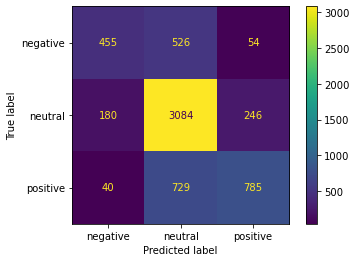

svm


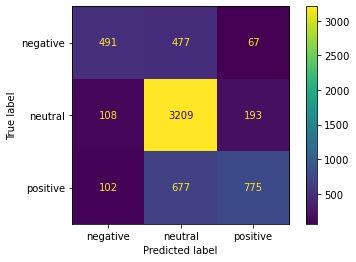

decision tree


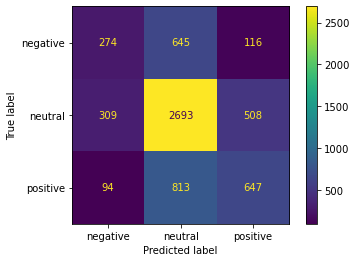

random forest


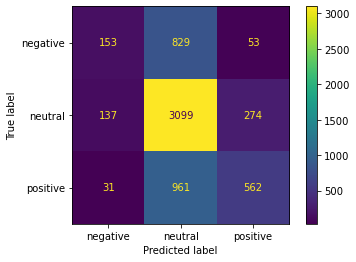

logi_stacking


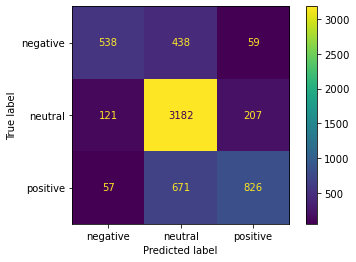

In [18]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

print('logistic regression')
plot_confusion_matrix(logi_model, X_validation, y_validation)
plt.show()

print('svm')
plot_confusion_matrix(svm_model, X_validation, y_validation)
plt.show()

print('decision tree')
plot_confusion_matrix(dt_model, X_validation, y_validation)
plt.show()

print('random forest')
plot_confusion_matrix(rf_model, X_validation, y_validation)
plt.show()

print('logi_stacking')
plot_confusion_matrix(logi_stacking, X_validation, y_validation)
plt.show()

In [19]:
import csv
prediction_label = logi_s_label
with open('prediction.csv','w') as output:
    output.write("id,sentiment\n")
    for i in range(0,len(prediction_label)):
        output.write(str(test_data['id'].iloc[i]))
        output.write(",")
        output.write(prediction_label[i])
        output.write('\n')

# report specific

In [20]:
print(CountVectorizer(ngram_range=(2,2)).fit_transform(X_train_raw).shape)
print(X_train_tranformed.shape)

(21802, 204657)
(21802, 169260)


# graphs

#### word count

neutral


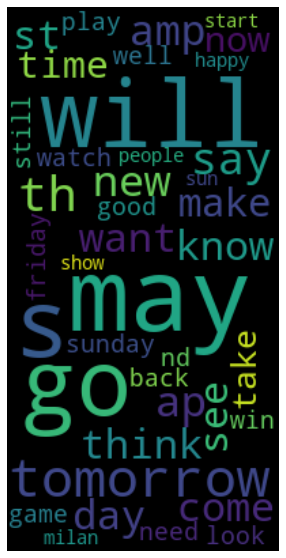

negative


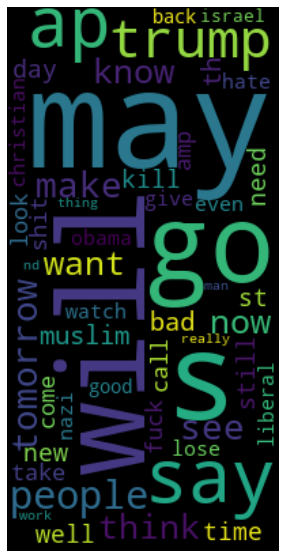

positive


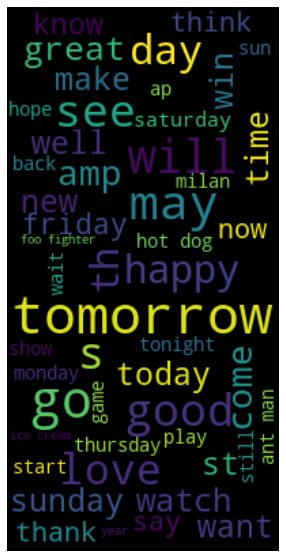

In [21]:
train_cleaned_df = pd.DataFrame({'text': X_train_clean, 'target': Y_train})
test_cleaned_df = pd.DataFrame(X_test_clean)
print("neutral")
neutral_tweets = train_cleaned_df[train_cleaned_df.target == 'neutral']
neutral_string = []
for t in neutral_tweets.text:
    neutral_string.append(t)
neutral_string = pd.Series(neutral_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=200, height=400,max_font_size=75, max_words=40).generate(neutral_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

print("negative")
negative_tweets = train_cleaned_df[train_cleaned_df.target == 'negative']
negative_string = []
for t in negative_tweets.text:
    negative_string.append(t)
negative_string = pd.Series(negative_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=200, height=400,max_font_size=100,max_words=50).generate(negative_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

print("positive")
positive_tweets = train_cleaned_df[train_cleaned_df.target == 'positive']
positive_string = []
for t in positive_tweets.text:
    positive_string.append(t)
positive_string = pd.Series(positive_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=200, height=400,max_font_size=100, max_words=50).generate(positive_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()